<a href="https://colab.research.google.com/github/andresdevml/dl_writing_quality/blob/main/data_experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exportamos librerias de interes**

In [333]:
import numpy as np

import pandas as pd

from sklearn import svm

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline

import keras

import tensorflow as tf

import matplotlib.pyplot as plt

from scipy import interpolate

from google.colab import drive



# **Importamos la data**

In [334]:
# conectamos al drive
drive.mount('/content/drive')

# Definimos el directorio
dir_data_kaggle='./drive/MyDrive/lwpwq/data'


# extraemos la data

df_train_logs=pd.read_csv(filepath_or_buffer=dir_data_kaggle+'/train_logs.csv')

df_train_scores=pd.read_csv(filepath_or_buffer=dir_data_kaggle+'/train_scores.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [335]:
# observemos las columnas presentes

df_train_logs.columns

Index(['id', 'event_id', 'down_time', 'up_time', 'action_time', 'activity',
       'down_event', 'up_event', 'text_change', 'cursor_position',
       'word_count'],
      dtype='object')

# **Feature Enginering**

**crearemos las caracteristicas una a una de manera manual, el data set sera un diccionario**


In [336]:
# primero hacemos el trabajo sobre todas las caractetisticas de una sola serie


id=df_train_logs['id'].unique()[1350]


df_data=df_train_logs[df_train_logs['id']==id]



# definimos una instancia de escaler

scaler=StandardScaler()

In [337]:
# action_time


action_time=scaler.fit_transform(df_data['action_time'].values.reshape(-1,1))

# delay

up_time_displaced=pd.concat(
                              objs=[  pd.Series([0]) ,   df_data['up_time']  ],
                              ignore_index=True
                                                            )

delay_time=scaler.fit_transform(
                                  (df_data['down_time'].values-up_time_displaced
                                    .iloc[0:-1]
                                    .values)
                                    .reshape(-1,1)
                                                            )



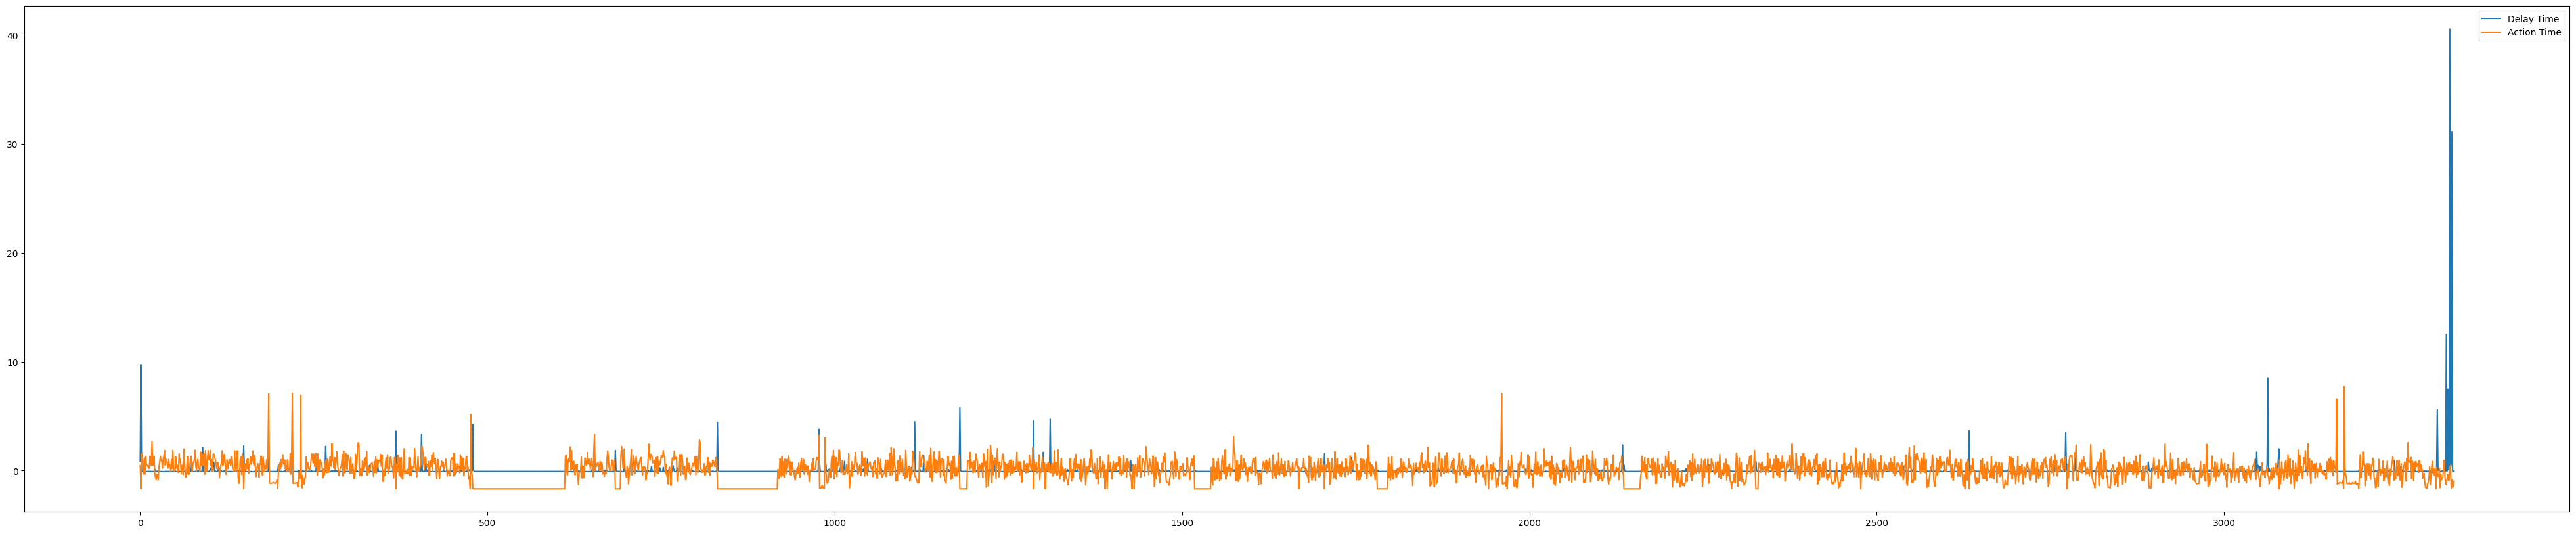

In [338]:
# grafiquemos para ver

plt.figure(figsize=(50,10))
plt.plot(delay_time, label='Delay Time')
plt.plot(action_time, label='Action Time')
plt.legend()
plt.show()


In [339]:
# activity

vocab_cut=df_train_logs['activity'].apply(lambda x: x[:3])

# veamos las categorias resultnates

vocab_cut.unique()

array(['Non', 'Inp', 'Rem', 'Rep', 'Mov', 'Pas'], dtype=object)

In [340]:
# veamos la frecuencioa de cada evento

vocab_cut.value_counts(normalize=True)*100

Inp    80.024716
Rem    11.541396
Non     8.373299
Rep     0.052915
Pas     0.007126
Mov     0.000547
Name: activity, dtype: float64

In [341]:
# la aplicacion de la funcion

fun_vocab_cut=vocab_cut.value_counts(normalize=True).apply(lambda x: np.log(1/x)).cumsum()
print(fun_vocab_cut)

Inp     0.222835
Rem     2.382065
Non     4.862187
Rep    12.406421
Pas    21.955604
Mov    34.071406
Name: activity, dtype: float64


In [342]:
# veamos el vocabulario en orden

print(vocab_cut.value_counts(normalize=True).index.values)

['Inp' 'Rem' 'Non' 'Rep' 'Pas' 'Mov']


In [343]:
# organizamos

vocab_cut=vocab_cut.value_counts(normalize=True).index.values

# extraemos la data

activity_cut=df_data['activity'].apply(lambda x: x[:3])

In [344]:
# creamos el diccionario de mapeo

map_dic_activity={}
for element in zip(vocab_cut,fun_vocab_cut):
  map_dic_activity[element[0]]=element[1]

# veamos el resultado

print(map_dic_activity)

{'Inp': 0.2228346492895395, 'Rem': 2.3820645857603324, 'Non': 4.8621867810316814, 'Rep': 12.406421105384979, 'Pas': 21.955603667553245, 'Mov': 34.07140643134787}


In [345]:
# aplicamos la categorizacion

cat_activity=np.array(
    activity_cut.apply(lambda x: map_dic_activity[x])).reshape(-1,1)




In [346]:
cat_activity.shape

(3332, 1)

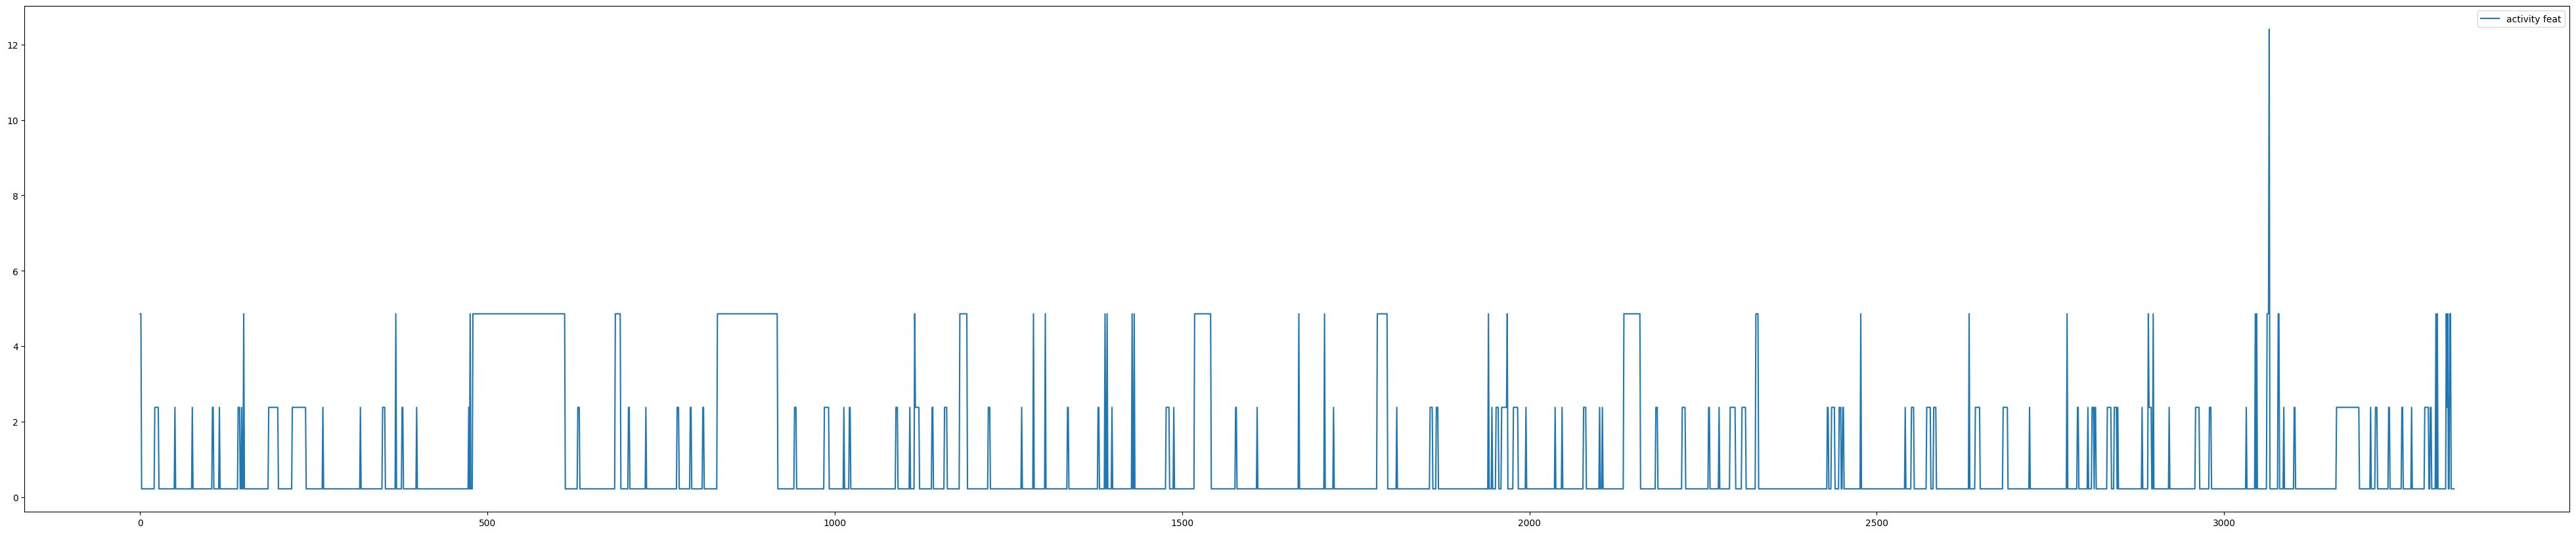

In [347]:
# veamos como queda

plt.figure(figsize=(50,10))
plt.plot(cat_activity, label='activity feat')
plt.legend()
plt.show()


In [348]:
# activity_mod


# definimos la funcion auxiliar 1
def mod_act(str_arr):
  if str_arr=='NoChange':

    return 0

  else:

    if ' => ' in str_arr:

      str_split=str_arr.split(' => ', maxsplit=1)

      return len(str_split[0])+len(str_split[1])

    else:

      return len(str_arr)

# funcion auxiliar 2
def cut_act(len_act):
  if len_act>=2:
    return 2
  else:
    return len_act


In [349]:

# veamos la distribucion

df_train_logs['text_change'].apply(mod_act).apply(cut_act).value_counts(normalize=True)*100



1    91.527461
0     8.373299
2     0.099240
Name: text_change, dtype: float64

In [350]:
# veamos queda al aplicar la funcion

df_train_logs['text_change'].apply(mod_act).apply(cut_act).value_counts(normalize=True).apply(lambda x: np.log(1/x)).cumsum()


1    0.088531
0    2.568653
2    9.484039
Name: text_change, dtype: float64

In [351]:
# creamos las variables del dic


index=df_train_logs['text_change'].apply(mod_act).apply(cut_act).value_counts(normalize=True).index.values

fun_map=df_train_logs['text_change'].apply(mod_act).apply(cut_act).value_counts(normalize=True).apply(lambda x: np.log(1/x)).cumsum()

# creamos el dic

map_dic_mod_activity={}

for element in zip(index,fun_map):
  map_dic_mod_activity[element[0]]=element[1]

# veamos el resultado

print(map_dic_mod_activity)

{1: 0.08853114028924959, 0: 2.5686533355605987, 2: 9.484039221087423}


In [352]:
# aplicamos el apply


activity_mod=df_data['text_change'].apply(mod_act).apply(cut_act)

cat_activity=np.array(activity_mod.apply(lambda x: map_dic_mod_activity[x])).reshape(-1,1)



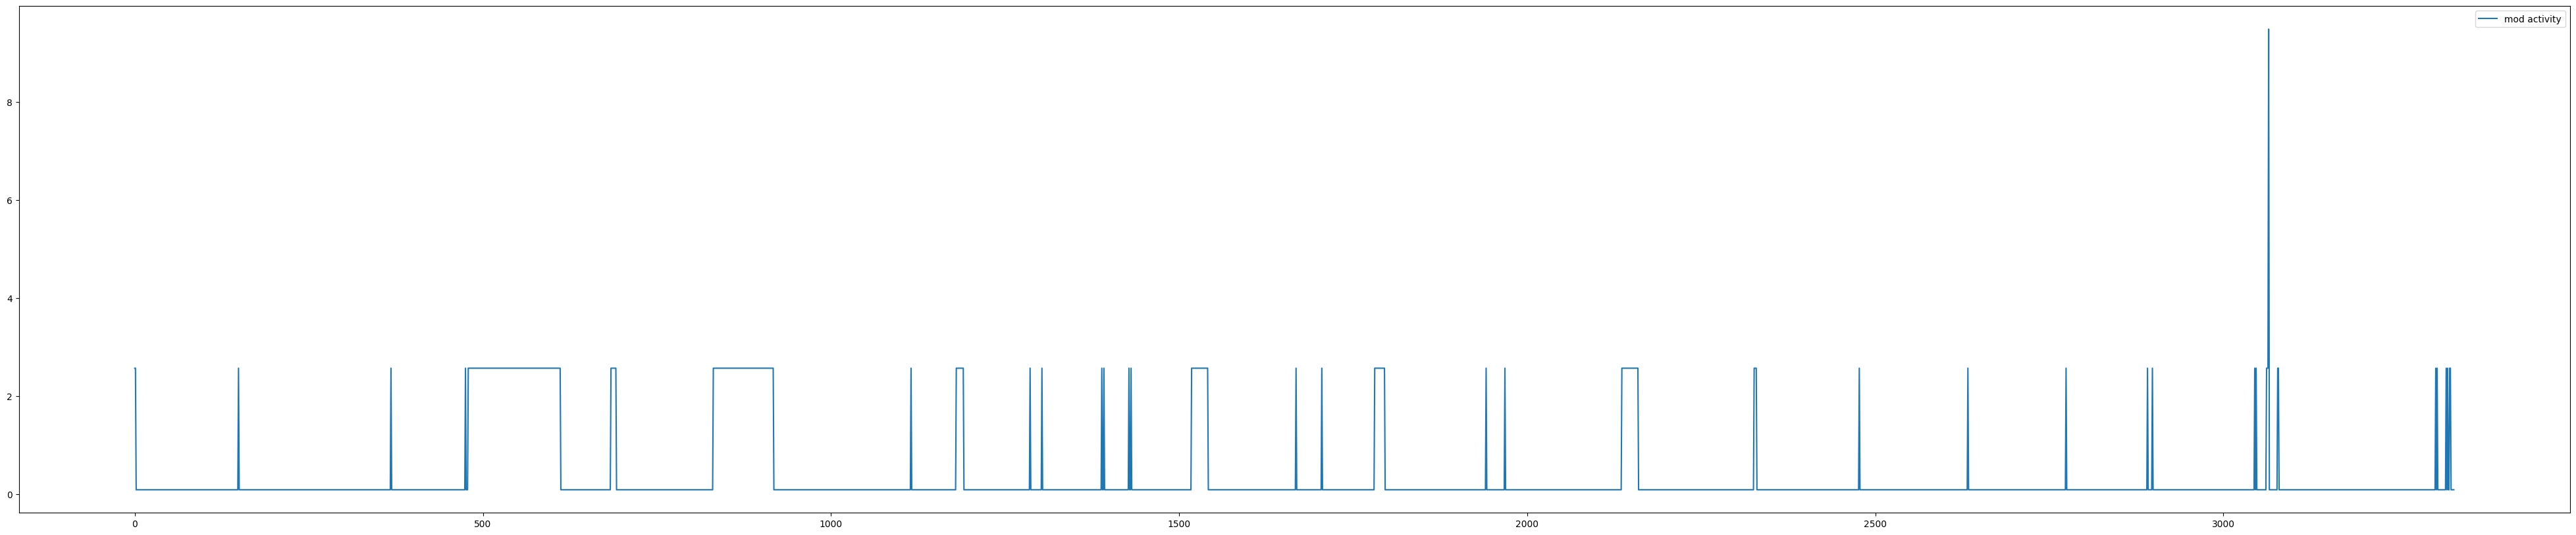

In [353]:
# veamos como queda

plt.figure(figsize=(50,10))
plt.plot(cat_activity, label='mod activity')
plt.legend()
plt.show()


In [354]:
# vocabulario de up_event and down_event
# veamos como se distribuyen los eventos

df_event=pd.concat(objs=[df_train_logs['down_event'],df_train_logs['up_event']],axis=0,ignore_index=True)

vocab=list(df_event.value_counts(normalize=True)[:13].index.values)

print(vocab)

print('\n')

print(df_event.value_counts(normalize=True)[:13]*100)

['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',', 'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock']


q             63.824876
Space         14.360488
Backspace     11.469197
Shift          3.976101
ArrowRight     1.443486
Leftclick      1.084072
ArrowLeft      0.752055
.              0.708859
,              0.556823
ArrowDown      0.367290
ArrowUp        0.335348
Enter          0.269918
CapsLock       0.149514
dtype: float64


In [355]:
layer = tf.keras.layers.StringLookup(vocabulary=vocab,
                                      num_oov_indices=1,
                                     output_mode='int')

In [356]:
pd.Series(layer(df_event)).value_counts(normalize=True).apply(lambda x: np.log(1/x)).cumsum()

1      0.449027
2      2.389717
3      4.555222
4      7.780091
5     12.018199
6     16.542645
7     21.432761
8     26.382029
0     31.341062
9     36.531739
10    42.138514
11    47.836271
12    53.751079
13    60.256614
dtype: float64

In [357]:
index=pd.Series(layer(df_event)).value_counts(normalize=True).index.values

fun_map=pd.Series(layer(df_event)).value_counts(normalize=True).apply(lambda x: np.log(1/x)).cumsum()

# creamos el dic

map_dic_event={}

for element in zip(index,fun_map):
  map_dic_event[element[0]]=element[1]

# veamos el resultado

print(map_dic_event)

{1: 0.4490271610497817, 2: 2.389716778823501, 3: 4.555222046124647, 4: 7.780090524582123, 5: 12.018199366116235, 6: 16.542645083212303, 7: 21.432760712189907, 8: 26.38202894634221, 0: 31.341061746707922, 9: 36.53173922817527, 10: 42.138513703717194, 11: 47.836270754094144, 12: 53.751079409853716, 13: 60.256614390201975}


In [358]:
# mapeamos

down_event=pd.Series(layer(df_data['down_event'])).apply(lambda x: map_dic_event[x])

up_event=pd.Series(layer(df_data['up_event'])).apply(lambda x: map_dic_event[x])

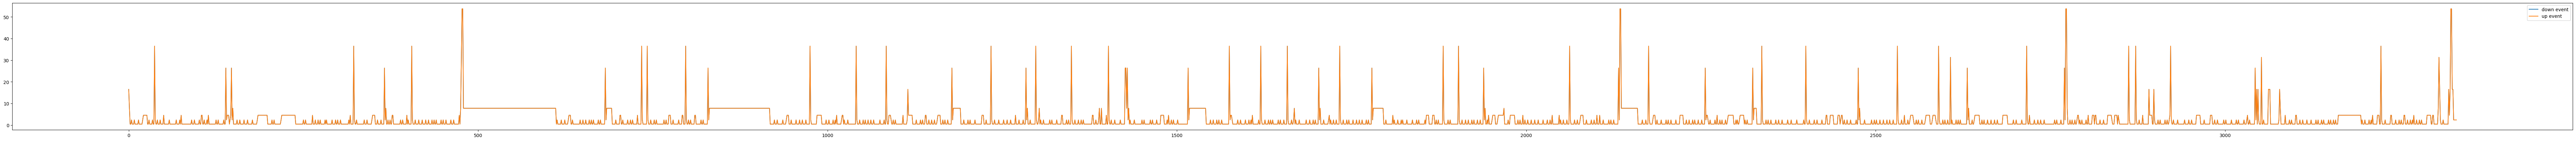

In [359]:
# visualizamos


plt.figure(figsize=(100,5))
plt.plot(down_event, label='down event')
plt.plot(up_event, label='up event')
plt.legend()
plt.show()


In [360]:
# cursor position

aux_ts=df_data['cursor_position']

cursor_position=aux_ts.values

# provemos el svr

regr_cp = make_pipeline(StandardScaler(), svm.SVR(kernel='linear',C=5, epsilon=10e-12))

regr_cp.fit(
    np.arange(len(cursor_position)).reshape(-1,1),
    cursor_position.reshape(-1,1))

cursor_position_lin=regr_cp.predict(
                                  np.arange(
                                                  len(cursor_position)
                                                            ).reshape(-1,1)
                                                                  )


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


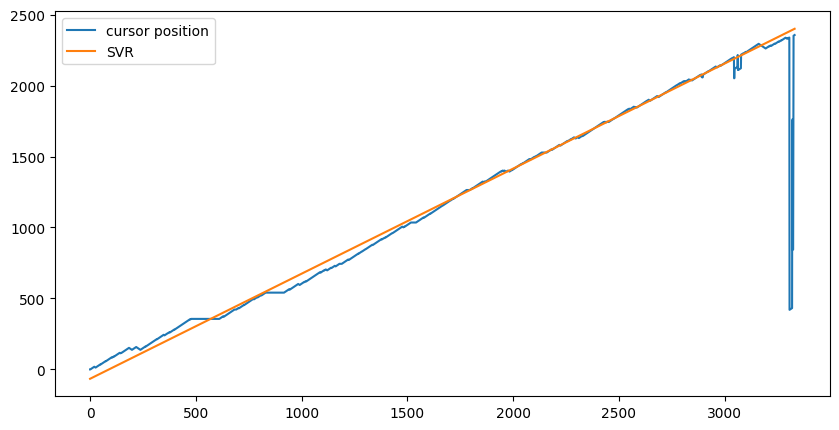

In [361]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(cursor_position)),cursor_position, label='cursor position')
plt.plot(np.arange(len(cursor_position)),cursor_position_lin, label='SVR')
plt.legend()
plt.show()

In [362]:
# cursor_position_feat


cursor_position_flat=((-1)*(cursor_position-cursor_position_lin)).reshape(-1,1)
cursor_position_flat=scaler.fit_transform(cursor_position_flat) # aqui estandarizamos

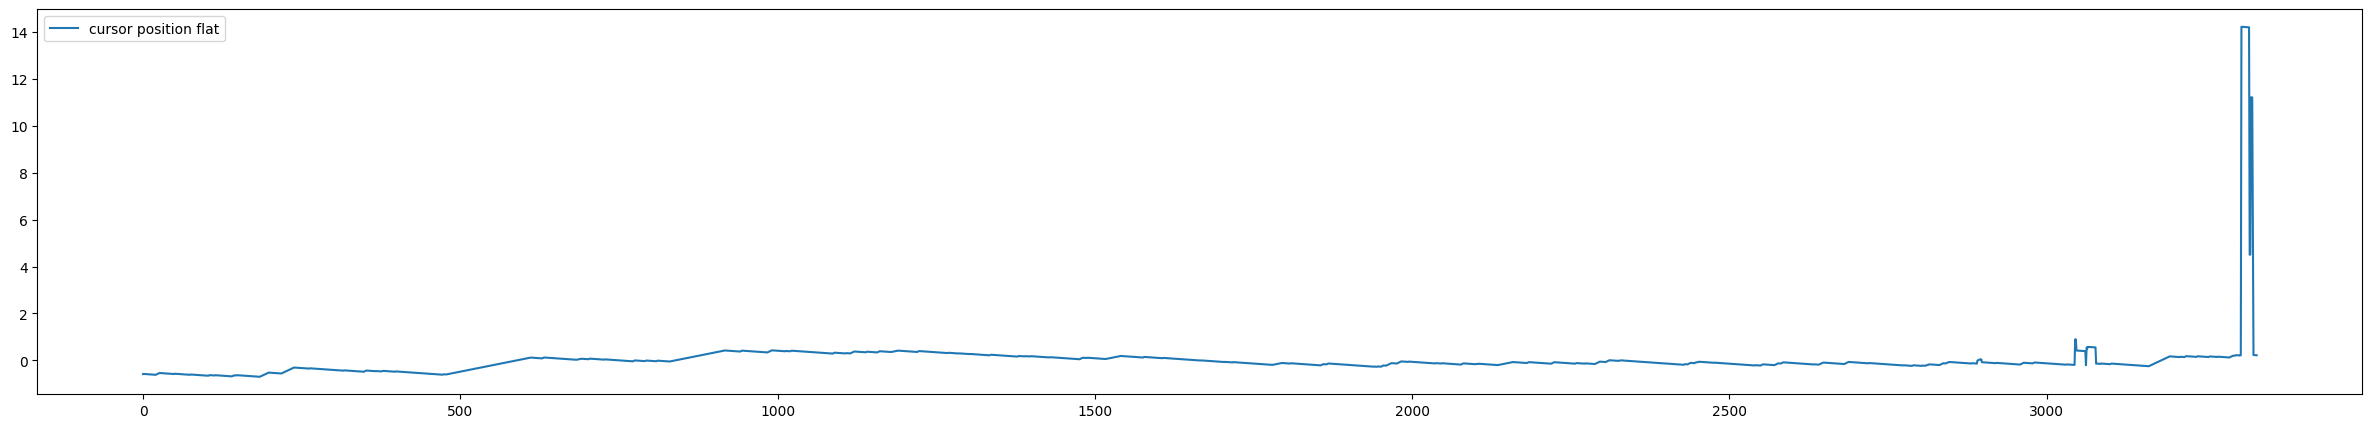

In [363]:
# establecemos la caracteristica sin la tendencia lineal

scaler = StandardScaler()


plt.figure(figsize=(30,5))
plt.plot(np.arange(len(cursor_position)),cursor_position_flat, label='cursor position flat')
plt.legend()
plt.show()

In [364]:

# aplicamos el mismo procedimiento anterior para word count

# word count

aux_ts=df_data['word_count']

word_count=aux_ts.values


# provemos el svr

regr_wc = make_pipeline(StandardScaler(), svm.SVR(kernel='linear',C=5, epsilon=10e-12))

regr_wc.fit(
    np.arange(len(word_count)).reshape(-1,1),
    word_count.reshape(-1,1))

word_count_lin=regr_wc.predict(
                                  np.arange(
                                                  len(word_count)
                                                            ).reshape(-1,1)
                                                                  )


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


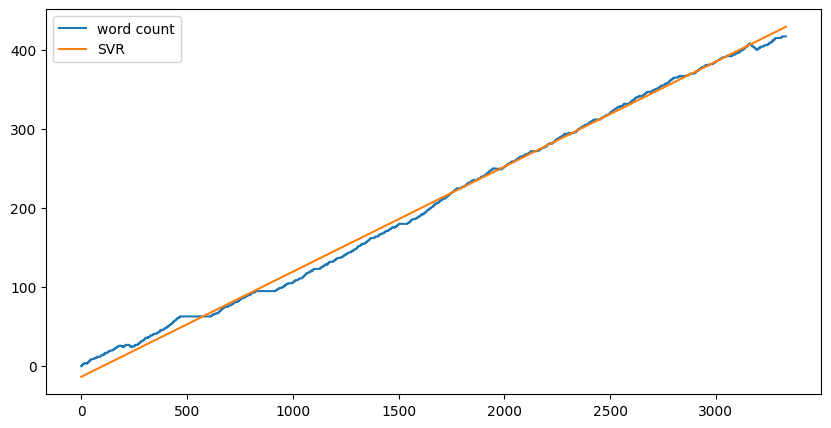

In [365]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(word_count)),word_count, label='word count')
plt.plot(np.arange(len(word_count)),word_count_lin, label='SVR')
plt.legend()
plt.show()

In [366]:

word_count_flat=((-1)*(word_count-word_count_lin)).reshape(-1,1)
word_count_flat=scaler.fit_transform(word_count_flat) # aqui estandarizamos

# hacemos una interpolacion

x_dense=np.arange(len(cursor_position))


index_interp=np.floor(np.linspace(x_dense[0], x_dense[-1] ,int(len(x_dense)*0.01))).astype(int)

x=x_dense[index_interp]

y=np.squeeze(word_count_flat[index_interp])

f = interpolate.interp1d(x, y,'nearest-up')

word_count_flat_intp=f(np.arange(len(cursor_position))).reshape(-1,1)

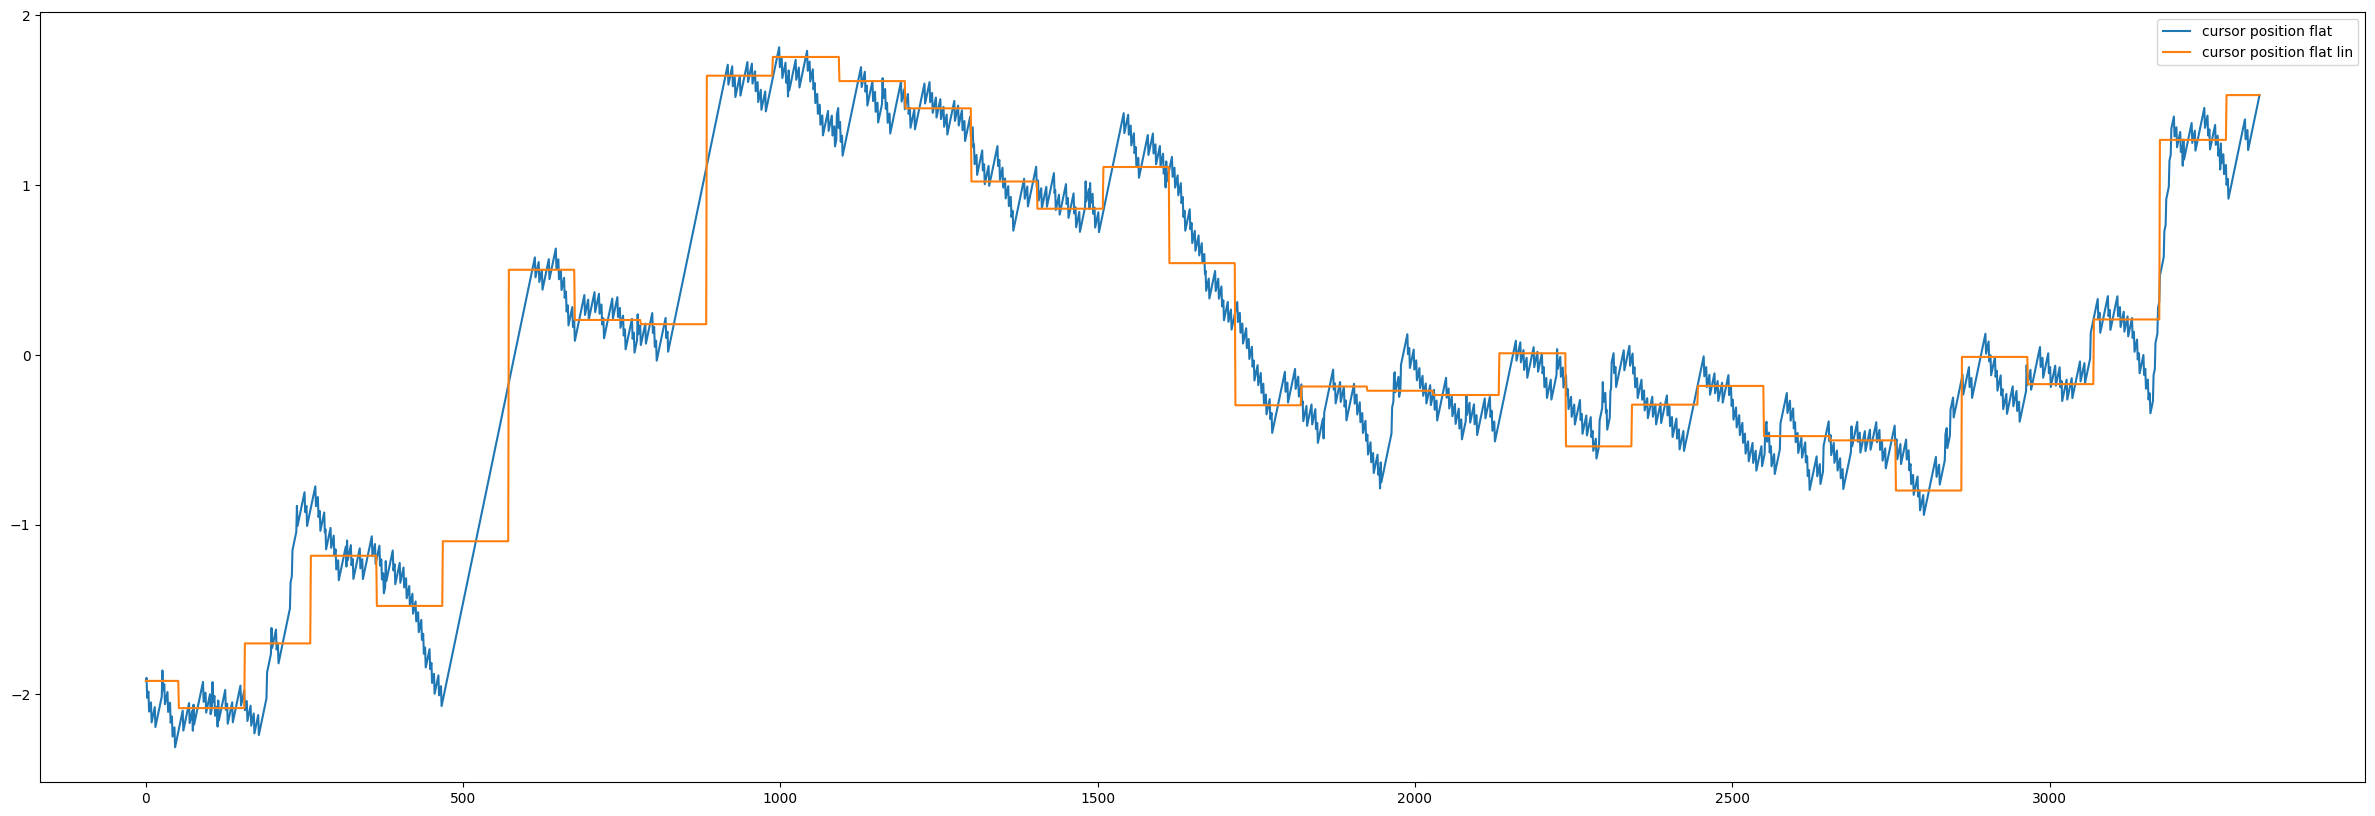

In [367]:
# establecemos la caracteristica sin la tendencia lineal


plt.figure(figsize=(30,10))
plt.plot(x_dense,word_count_flat, label='cursor position flat')
plt.plot(x_dense,word_count_flat_intp, label='cursor position flat lin')
plt.legend()

plt.show()

In [368]:

# change text

# definimos una funcion de transformacion

def text_change_format(pd_serie):

  aux_serie=pd_serie.copy(deep=True)
  for row,value in enumerate(aux_serie):
    if ' => ' in value:
      aux_serie.iloc[row]='=>'
  return aux_serie

# aplicamos la funcion de transformacion

tc_transf=text_change_format(df_train_logs['text_change'])

tc_transf.value_counts(normalize=True)[:12]*100


q           72.903668
            16.379321
NoChange     8.373299
.            0.806541
,            0.651888
\n           0.332826
'            0.156937
"            0.055425
-            0.053439
=>           0.052915
?            0.041721
;            0.034559
Name: text_change, dtype: float64

In [369]:
tc_transf.value_counts(normalize=True)[:12].sum()*100


99.8425391314527

In [370]:
# Definimos la capa

vocab_tc=tc_transf.value_counts(normalize=True)[:25].index.values

layer_tc= tf.keras.layers.StringLookup(vocabulary=vocab_tc,
                                            num_oov_indices=1,
                                                  output_mode='int')



In [371]:

# aplicamos la transformacion
pd.Series(layer_tc(text_change_format(df_train_logs['text_change'])) ).value_counts(normalize=True)*100

1     72.903668
2     16.379321
3      8.373299
4      0.806541
5      0.651888
6      0.332826
7      0.156937
8      0.055425
9      0.053439
10     0.052915
0      0.050357
11     0.041721
12     0.034559
13     0.027219
14     0.016108
15     0.013086
16     0.009672
17     0.008720
18     0.008625
19     0.007852
20     0.007602
21     0.002106
22     0.001868
23     0.001630
24     0.001332
25     0.001285
dtype: float64

# **caracteristicas estaticas**



In [372]:
len_time=np.maximum(df_data['up_time'].max(),df_data['down_time'].max())/np.maximum(df_train_logs['up_time'].max(),df_train_logs['down_time'].max())
print(len_time)

0.21714705606055157


In [373]:
len_word=df_data['word_count'].max()/df_train_logs['word_count'].max()
print(len_word)

0.31447963800904977


In [374]:
len_cursor_position=df_data['cursor_position'].max()/df_train_logs['cursor_position'].max()
print(len_cursor_position)

0.30197385285824146


# **Armamos el dicionario**

In [375]:
# veamos la data

print(id)

8e5a0aed


In [376]:
# veamos las dimensiones

delay_time.shape

(3332, 1)

In [377]:
action_time.shape

(3332, 1)

In [378]:
activity_cat.shape

NameError: ignored

In [ ]:
cursor_position_flat.shape

In [ ]:
word_count_flat_intp.shape

In [ ]:
tc_feat.shape

In [ ]:
# concatenamos la data

dyn_data=np.hstack(
                      tup=(   delay_time,
                              action_time,
                              activity_cat,
                              mod_activity,
                              cursor_position_flat,
                              word_count_flat_intp,
                              tc_feat     )
                                                  )


stat_data=np.hstack(

                          tup=(len_time,len_word,len_cursor_position)

                              )

target=df_train_scores[df_train_scores['id']==id]['score'].values

In [ ]:
train_data_example={

    '0a21bbd6':

     {
        'dyn_data':dyn_data,
        'stat_data':stat_data,
        'target':target
                              }
                                      }

In [ ]:
train_data_example